**Sentiment Analysis of COVID-19 Tweets Using TF-IDF Vectorization**  
**Author:** Nikolai Ramalingam  
**Date:** 8/1/24  
**Contact:** nikolair@g.ucla.edu  
This notebook demonstrates the application of TF-IDF vectorization for classifying sentiments in tweets about the coronavirus. It covers data preprocessing, vectorization, model training, and evaluation.

In [3]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import ComplementNB
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
file_path = "/Users/nikolairamalingam/Desktop/cvirl/corona_data"
train_data = pd.read_csv(file_path + "/Corona_NLP_train.csv", encoding='ISO-8859-1')
test_data = pd.read_csv(file_path + "/Corona_NLP_test.csv", encoding='ISO-8859-1')

train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
def build_dataset(train_data, test_data):
    # combines sentiments to improve performance
    train_data['Sentiment'] = train_data['Sentiment'].replace({'Extremely Negative': 'Negative', 'Extremely Positive': 'Positive'})
    test_data['Sentiment'] = test_data['Sentiment'].replace({'Extremely Negative': 'Negative', 'Extremely Positive': 'Positive'})
    X_train, y_train = train_data['OriginalTweet'], train_data['Sentiment']
    X_test, y_test = test_data['OriginalTweet'], test_data['Sentiment']
    categories = sorted(list(set(y_train)))
    return X_train, X_test, y_train, y_test, categories

X_train, X_test, y_train, y_test, categories = build_dataset(train_data, test_data)
print("Training data class distribution:")
print(y_train.value_counts())

Training data class distribution:
Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64


In [12]:
# Embed tweets
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, strip_accents='unicode', stop_words="english")
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Fit training data to clf
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  
}
clf = LogisticRegression() # Yielded best results among complement naive bayes, multinomial naive bayes, and ridgeclassifier
grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)
best_clf = grid_search.best_estimator_
pred = best_clf.predict(X_test_transformed)

# Score predictions
score = metrics.accuracy_score(y_test, pred)
print("Test accuracy score:", score)

# Detailed classification report
report = metrics.classification_report(y_test, pred, target_names=np.unique(y_train))
print(report)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Test accuracy score: 0.817798841495524
              precision    recall  f1-score   support

    Negative       0.84      0.81      0.82      1633
     Neutral       0.72      0.77      0.74       619
    Positive       0.84      0.85      0.84      1546

    accuracy                           0.82      3798
   macro avg       0.80      0.81      0.80      3798
weighted avg       0.82      0.82      0.82      3798



In [ ]:
def predict_sentiment(text, vectorizer, classifier):
    text_transformed = vectorizer.transform([text])
    prediction = classifier.predict(text_transformed)
    return prediction[0]

# Example usage
new_string = "COVID"
predicted_sentiment = predict_sentiment(new_string, vectorizer, best_clf)
print(f"The sentiment of the new string is: {predicted_sentiment}")

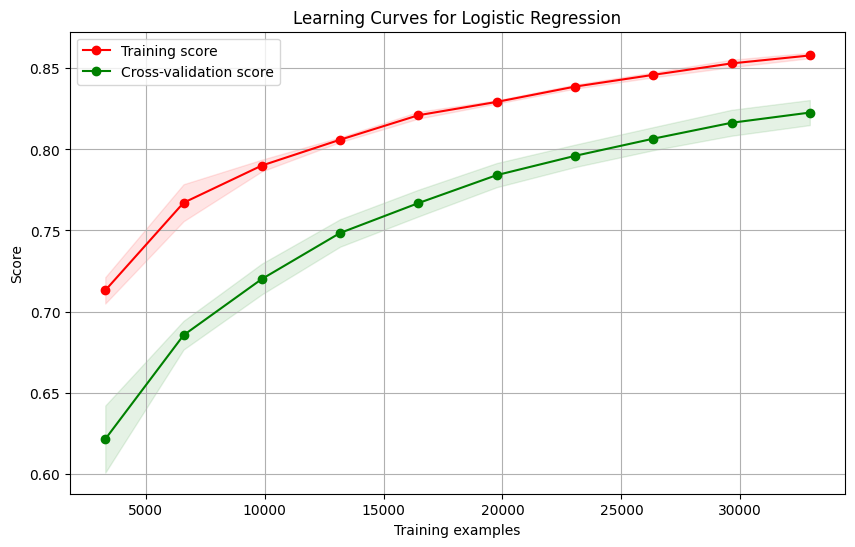

In [13]:
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_clf,
    X=X_train_transformed,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # From 10% to 100% of the training data
    cv=5,  # Cross-validation splitting strategy
    scoring='accuracy'  # Evaluation metric
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curves for Logistic Regression')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

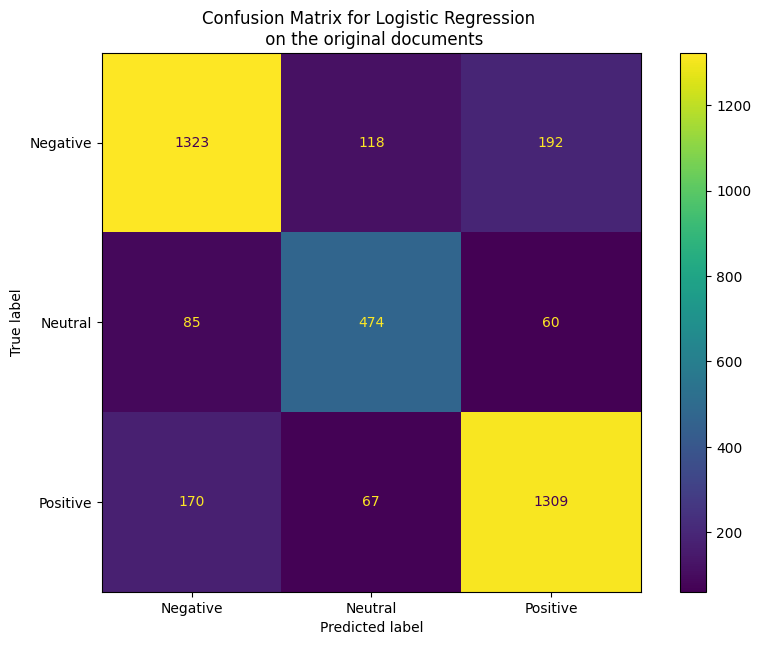

In [236]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(categories)
ax.yaxis.set_ticklabels(categories)
_ = ax.set_title("Confusion Matrix for Logistic Regression \n on the original documents")